In [3]:
import os

base_path = "/kaggle/input"
for folder in os.listdir(base_path):
    print("📁", folder)
    inner = os.path.join(base_path, folder)
    for f in os.listdir(inner):
        print("   └──", f)


📁 efficient-netb3
   └── deepfake_efficientnet_b3_best.keras
📁 140k-real-and-fake-faces
   └── valid.csv
   └── real_vs_fake
   └── train.csv
   └── test.csv
📁 d
   └── imshan22


In [5]:
import tensorflow as tf
from keras.layers import TFSMLayer
from keras import Model, Input

# Path to your converted SavedModel
path = "/kaggle/input/d/imshan22/xception/converted_xception_savedmodel"

# Load SavedModel as a Keras-compatible layer
xception_layer = TFSMLayer(path, call_endpoint="serving_default")

# Rewrap it as a model (so you can call model.predict etc.)
inp = Input(shape=(299, 299, 3))  # Xception input shape
out = xception_layer(inp)
model = Model(inputs=inp, outputs=out)

# Test
model.summary()


I0000 00:00:1762526883.525134      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762526883.525870      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 299, 299, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tfsm_layer (TFSMLayer)          │ (None, 1)              │    21,386,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,386,281 (81.58 MB)

 Trainable params: 21,331,753 (81.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

✅ Both models loaded successfully!



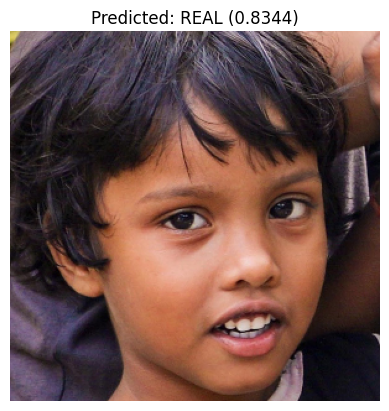


🧠 Xception Prediction: 0.9891
🧠 EfficientNetB3 Prediction: 0.6797
⚡ Ensemble Average: 0.8344
✅ Final Label: REAL


In [25]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

# === 1️⃣ Load Xception (from SavedModel) ===
xception_layer = tf.keras.layers.TFSMLayer(
    "/kaggle/input/d/imshan22/xception/converted_xception_savedmodel",
    call_endpoint="serving_default"
)
inp = tf.keras.Input(shape=(299, 299, 3))
out = xception_layer(inp)
xception_model = tf.keras.Model(inputs=inp, outputs=out)

# === 2️⃣ Load EfficientNetB3 (.keras file) ===
efficientnet_model = load_model(
    "/kaggle/input/efficient-netb3/deepfake_efficientnet_b3_best.keras",
    compile=False
)

print("✅ Both models loaded successfully!\n")

# === 3️⃣ Preprocessing functions ===
def preprocess_for_xception(img_path):
    img = image.load_img(img_path, target_size=(299, 299))
    img_array = image.img_to_array(img)
    img_array = tf.keras.applications.xception.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array, img

def preprocess_for_efficientnet_b3(img_path):
    img = image.load_img(img_path, target_size=(300, 300))
    img_array = image.img_to_array(img)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# === 4️⃣ Ensemble Prediction ===
def ensemble_predict(img_path):
    # Prepare inputs
    x_inp, img_display = preprocess_for_xception(img_path)
    e_inp = preprocess_for_efficientnet_b3(img_path)

    # Predict
    pred_x = xception_model.predict(x_inp, verbose=0)
    if isinstance(pred_x, dict):  # happens with TFSMLayer
        pred_x = list(pred_x.values())[0]

    pred_e = efficientnet_model.predict(e_inp, verbose=0)

    # Average (soft voting)
    final_pred = (pred_x + pred_e) / 2
    label = "REAL" if final_pred[0][0] > 0.5 else "FAKE"


    # Display results
    plt.imshow(img_display)
    plt.axis("off")
    plt.title(f"Predicted: {label} ({final_pred[0][0]:.4f})")
    plt.show()

    print(f"\n🧠 Xception Prediction: {pred_x[0][0]:.4f}")
    print(f"🧠 EfficientNetB3 Prediction: {pred_e[0][0]:.4f}")
    print(f"⚡ Ensemble Average: {final_pred[0][0]:.4f}")
    print(f"✅ Final Label: {label}")


# === 5️⃣ Test on any image ===
test_image_path = "/kaggle/input/real-and-fake-face-detection/real_and_fake_face/training_real/real_00001.jpg"
ensemble_predict(test_image_path)


In [14]:
# Pick a test image path
test_image_path = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake/008BYSE725.jpg"

# Preprocess for Xception
x_inp, img_display = preprocess_for_xception(test_image_path)

# Now predict
pred_x = xception_model.predict(x_inp, verbose=0)
print("Xception raw output:", pred_x)


Xception raw output: {'dense_1': array([[0.21332183]], dtype=float32)}


In [15]:
e_inp = preprocess_for_efficientnet_b3(test_image_path)
pred_e = efficientnet_model.predict(e_inp, verbose=0)
print("EfficientNetB3 output:", pred_e)


EfficientNetB3 output: [[0.01009471]]


In [17]:
real_image_path = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/real/00001.jpg"

x_inp, _ = preprocess_for_xception(real_image_path)
pred_x = xception_model.predict(x_inp, verbose=0)
pred_x = list(pred_x.values())[0] if isinstance(pred_x, dict) else pred_x

e_inp = preprocess_for_efficientnet_b3(real_image_path)
pred_e = efficientnet_model.predict(e_inp, verbose=0)

final_pred = (pred_x + pred_e) / 2

print("Xception:", pred_x)
print("EfficientNetB3:", pred_e)
print("Ensemble:", final_pred)


Xception: [[0.99551165]]
EfficientNetB3: [[0.99999917]]
Ensemble: [[0.9977554]]
